<a href="https://colab.research.google.com/github/MARCIANO04/Marcianosawael_TM9/blob/main/UAS_DeepL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install roboflow -q

from roboflow import Roboflow

rf = Roboflow(api_key="RIdx6tzX5sOfU0fl6Ia9")
project = rf.workspace("marciano-sawael").project("flower_dataset-k0wac")
version = project.version(1)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [26]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



In [28]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

dataset_path = glob.glob("Flower_Dataset-1")[0]
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
label_map = train_generator.class_indices
print("Class Mapping:", label_map)



Found 151 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
Class Mapping: {'black eyed': 0, 'iris': 1, 'rose': 2}


In [29]:
def compile_train(model, name):
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"\n=== Training {name} ===\n")
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=15)

    loss, acc = model.evaluate(test_generator)

    # Prediksi untuk F1-Score dan klasifikasi
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_true, y_pred_labels, average='weighted')
    report = classification_report(y_true, y_pred_labels, target_names=label_map.keys())

    print(f"\n{name} Test Accuracy: {acc:.4f}, Loss: {loss:.4f}, F1-Score: {f1:.4f}")
    print(f"\nClassification Report:\n{report}")

    return history, acc, loss, f1



In [30]:
cnn_model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn_history, cnn_acc, cnn_loss, cnn_f1 = compile_train(cnn_model, "CNN")




=== Training CNN ===

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.3668 - loss: 1.1295 - val_accuracy: 0.5000 - val_loss: 1.0632
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4444 - loss: 1.0273 - val_accuracy: 0.8333 - val_loss: 0.8526
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7042 - loss: 0.8527 - val_accuracy: 0.8333 - val_loss: 0.6494
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8020 - loss: 0.6825 - val_accuracy: 0.7222 - val_loss: 0.6696
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7180 - loss: 0.6271 - val_accuracy: 0.7778 - val_loss: 0.5550
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7608 - loss: 0.6482 - val_accuracy: 0.8333 - val_loss: 0.4635
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8188 - loss: 0.4726 - val_accuracy: 0.8333 - val_loss: 0.4648
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7775 - loss: 0.4594 - val_accuracy: 0.8333 - va

In [31]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_resnet.layers:
    layer.trainable = False

resnet_model = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

resnet_history, resnet_acc, resnet_loss, resnet_f1 = compile_train(resnet_model, "ResNet50")



=== Training ResNet50 ===

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.3052 - loss: 1.4365 - val_accuracy: 0.3333 - val_loss: 1.1144
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.3120 - loss: 1.3808 - val_accuracy: 0.3333 - val_loss: 1.1155
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.3819 - loss: 1.2956 - val_accuracy: 0.2778 - val_loss: 1.1242
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.3244 - loss: 1.4125 - val_accuracy: 0.2778 - val_loss: 1.1318
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.3979 - loss: 1.2930 - val_accuracy: 0.2778 - val_loss: 1.1416
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.2985 - loss: 1.3156 - val_accuracy: 0.2778 - val_loss: 1.1355
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.3197 - loss: 1.3850 - val_accuracy: 0.3889 - val_loss: 1.1182
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.3005 - loss: 1.3486 - val_accuracy: 0.3333

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [32]:
base_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_eff.layers:
    layer.trainable = False

eff_model = Sequential([
    base_eff,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

eff_history, eff_acc, eff_loss, eff_f1 = compile_train(eff_model, "EfficientNetB0")




=== Training EfficientNetB0 ===

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3867 - loss: 1.1252 - val_accuracy: 0.2778 - val_loss: 1.1072
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3863 - loss: 1.1299 - val_accuracy: 0.2778 - val_loss: 1.1270
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3970 - loss: 1.1508 - val_accuracy: 0.2778 - val_loss: 1.1237
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4190 - loss: 1.1231 - val_accuracy: 0.2778 - val_loss: 1.1142
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3307 - loss: 1.1418 - val_accuracy: 0.2778 - val_loss: 1.1096
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3232 - loss: 1.1431 - val_accuracy: 0.2778 - val_loss: 1.1097
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.2691 - loss: 1.1184 - val_accuracy: 0.2778 - val_loss: 1.1125
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3985 - loss: 1.1050 - val_accuracy: 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


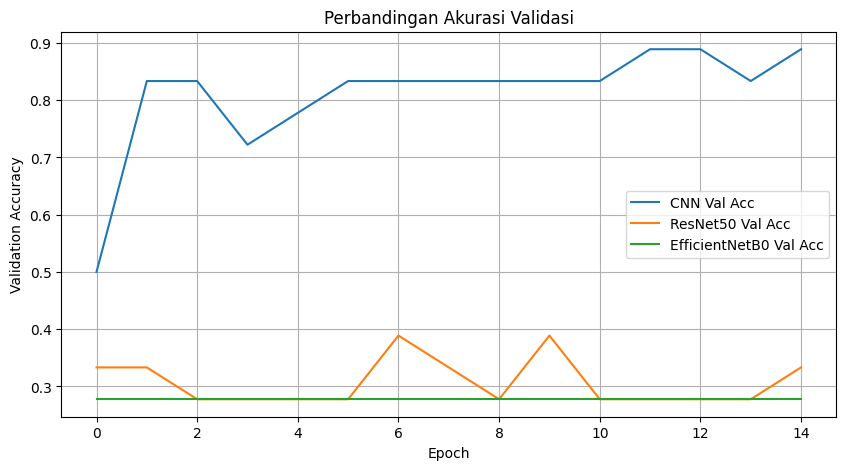

In [33]:
def plot_history(histories, title):
    plt.figure(figsize=(10,5))
    for label, hist in histories.items():
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history({
    "CNN": cnn_history,
    "ResNet50": resnet_history,
    "EfficientNetB0": eff_history
}, "Perbandingan Akurasi Validasi")


In [34]:
results = {
    "CNN": {"acc": cnn_acc, "loss": cnn_loss, "f1": cnn_f1},
    "ResNet50": {"acc": resnet_acc, "loss": resnet_loss, "f1": resnet_f1},
    "EfficientNetB0": {"acc": eff_acc, "loss": eff_loss, "f1": eff_f1},
}

print("\n=== RINGKASAN EVALUASI MODEL ===")
for name, metrics in results.items():
    print(f"{name:15} | Accuracy: {metrics['acc']:.4f} | F1-Score: {metrics['f1']:.4f} | Loss: {metrics['loss']:.4f}")

# Menentukan model terbaik (berdasarkan akurasi dan F1)
best_model = max(results.items(), key=lambda x: (x[1]['f1'], x[1]['acc']))
print(f"\n🏆 Model Terbaik: {best_model[0]} (F1: {best_model[1]['f1']:.4f}, Acc: {best_model[1]['acc']:.4f})")




=== RINGKASAN EVALUASI MODEL ===
CNN             | Accuracy: 0.8889 | F1-Score: 0.8963 | Loss: 0.1677
ResNet50        | Accuracy: 0.3333 | F1-Score: 0.2921 | Loss: 1.0562
EfficientNetB0  | Accuracy: 0.3333 | F1-Score: 0.1667 | Loss: 1.0704

🏆 Model Terbaik: CNN (F1: 0.8963, Acc: 0.8889)
